# 03_feature_selection

This notebook uses the Gaussian Naive Bayes Classifier to reduce the number of features that are used for the model. Different approaches to feature reduction are tested and compared. The benchmarks are the full data (Accuracy: 99,48%, F1: 99,47%) and the data with external features removed (Accuracy: 81,62%, F1: 79%).

Following sklearn methods to reduce features are tested: SelectKBest (k=30), SelectPercentile (percentile=70%), SelectFpr(alpha=0.05) with both ANOVA and Chi-Squared as parameteres, as well as VarianceThreshold(threshold=0).

The lowest number of features in combination with the highest Accuracy and F1 is SelectKBest_ANOVA. With 30 features the model scores an accuracy of 99,59% and F1 of 99,59%.

To find the ideal number of features, SelectKBest is tested with k = 1 - 49. The best result is k=42, with an accuracy and f1 of 99.66%. k=42 includes 12 of 15 external features.

In the line charts, three distinct increases of f1 are visible. k = 6 (acc: 93.8%, f1: 93.5%, ext_f: 2), 25 (acc: 97.28%, f1: 97.2%, ext_f: 5) and 29(acc: 99.59%, f1: 99.59%, ext_f: 7). The selection at this step needs to take f1 into account but also the number of external features and how important the reduction of features is.

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_validate, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, SelectFpr
from sklearn.feature_selection import f_classif, chi2

# load data
df = pd.read_csv('output/data_balanced.csv')

# split data into features and target
X = df.drop(columns=['seo class'])
y = df['seo class']

# dictionary of evaluation metrics
metrics = {'accuracy': 'accuracy',
           'precision': 'precision_macro', 
           'recall': 'recall_macro',
           'f1': 'f1_macro'}

# create stratified split for cross validation
sss = StratifiedShuffleSplit(n_splits=5, test_size=.66, random_state=22)

# define classifier
clf = GaussianNB()

# get list of external columns
external_cols = [c for c in df.columns if c.startswith(('micros', 'source', 'tools'))]

In [2]:
# empty dictionary to store results
cv_results = {}
feature_count = {}

# set up dict with selectors
selector = {'External Features': external_cols,
            'VarianceThreshold': VarianceThreshold(),
            'SelectKBest_ANOVA': SelectKBest(f_classif, k=30),
            'SelectKBest_chi2': SelectKBest(chi2, k=30),
            'SelectPercentile_ANOVA': SelectPercentile(f_classif, percentile=70),
            'SelectPercentile_chi2': SelectPercentile(chi2, percentile=70),
            'SelectFpr_ANOVA': SelectFpr(f_classif, alpha=0.05),
            'SelectFpr_chi2': SelectFpr(chi2, alpha=0.05)}

for method, s in selector.items():
    # reset X
    X = df.drop(columns=['seo class'])
    
    if type(s) == list:
        # remove external features
        X = X.drop(columns=s)
    else:
        # use current selector to reduce features
        X = s.fit_transform(X, y)
        
    X = StandardScaler().fit_transform(X)
    cv = cross_validate(clf, X, y, scoring=metrics, cv=sss)
    cv_results[method] = cv
    feature_count[method] = X.shape[1]

# format data for dataframe
data = []
for name, results in cv_results.items():
    row = [name, feature_count[name]]
    for k, v in results.items():
        # add mean and standard deviation to data
        row.append(v.mean())
        row.append(v.std())
    data.append(row)
    
# column names for dataframe
columns = ['method', 'feature_count']
for k in cv.keys():
    k = k.replace('test_', '')
    columns.append(k+'_mean')
    columns.append(k+'_std')

# create data frame to display cv results
results = pd.DataFrame(data, columns=columns)
# save data frame as csv file
results.to_csv('output/03_feature_selection.csv')
results.sort_values(by=['f1_mean'], ascending=False)

,method,feature_count,fit_time_mean,fit_time_std,score_time_mean,score_time_std,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std
2,SelectKBest_ANOVA,30,0.591648,0.013184,1.014623,0.023770,0.995963,0.000107,0.996017,0.000112,0.995845,0.000110,0.995920,0.000111
4,SelectPercentile_ANOVA,34,0.632065,0.006143,1.341800,0.018945,0.995761,0.000128,0.995807,0.000131,0.995649,0.000130,0.995718,0.000131
5,SelectPercentile_chi2,34,0.639327,0.005155,1.353544,0.006587,0.995093,0.000177,0.995113,0.000180,0.995000,0.000175,0.995051,0.000177
1,VarianceThreshold,49,0.914893,0.003921,1.684592,0.015657,0.994816,0.000087,0.994853,0.000089,0.994685,0.000088,0.994738,0.000088
6,SelectFpr_ANOVA,49,0.889187,0.009916,1.686743,0.010156,0.994816,0.000087,0.994853,0.000089,0.994685,0.000088,0.994738,0.000088
7,SelectFpr_chi2,49,0.898140,0.002574,1.690969,0.012178,0.994816,0.000087,0.994853,0.000089,0.994685,0.000088,0.994738,0.000088
3,SelectKBest_chi2,30,0.567440,0.004654,1.017478,0.009430,0.971516,0.000214,0.972913,0.000214,0.970754,0.000215,0.970796,0.000213
0,External Features,34,0.638202,0.002635,1.352546,0.014044,0.816252,0.001807,0.825872,0.001094,0.811003,0.001856,0.799008,0.002692


In [3]:
# empty dictionary to store results
cv_results = {}
feature_count = {}
ext_feature_count = {}
features = {}
ext_features = {}

for i in range(1, 49):
    
    # split data into features and target
    X = df.drop(columns=['seo class'])
    y = df['seo class']
    
    selector = SelectKBest(f_classif, k=i)
    X2 = selector.fit_transform(X, y)
    X2 = StandardScaler().fit_transform(X2)
    cv = cross_validate(clf, X2, y, scoring=metrics, cv=sss)
    
    features[i] = [i[0] for i in zip(X.columns, selector.get_support()) if i[1]==True]
    ext_features[i] = set(features[i]) & set(external_cols)
    
    cv_results[i] = cv
    feature_count[i] = len(features[i])
    ext_feature_count[i] = len(ext_features[i])

    
# format data for dataframe
data = []
for name, results in cv_results.items():
    row = [feature_count[name], ext_feature_count[name]]
    for k, v in results.items():
        # add mean and standard deviation to data
        row.append(v.mean())
        row.append(v.std())
    data.append(row)
    
# column names for dataframe
columns = ['feature_count', 'external_feature_count']
for k in cv.keys():
    k = k.replace('test_', '')
    columns.append(k+'_mean')
    columns.append(k+'_std')

# create data frame to display cv results
results = pd.DataFrame(data, columns=columns)
# save data frame as csv file
results.to_csv('output/03-5_selectkbest.csv')
results.sort_values(by=['f1_mean'], ascending=False).head(10)

,feature_count,external_feature_count,fit_time_mean,fit_time_std,score_time_mean,score_time_std,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std
41,42,12,0.780402,0.005350,1.522099,0.016559,0.996646,0.000104,0.996721,0.000106,0.996571,0.000106,0.996634,0.000106
40,41,11,0.761603,0.009693,1.520505,0.003556,0.996637,0.000144,0.996710,0.000148,0.996566,0.000145,0.996627,0.000146
39,40,11,0.737823,0.007232,1.488038,0.014901,0.996551,0.000171,0.996620,0.000175,0.996482,0.000170,0.996541,0.000172
42,43,12,0.808392,0.007888,1.535952,0.017864,0.996412,0.000121,0.996476,0.000124,0.996344,0.000122,0.996400,0.000123
28,29,7,0.551267,0.011036,1.006121,0.023934,0.995968,0.000105,0.996022,0.000110,0.995850,0.000108,0.995925,0.000109
29,30,8,0.561372,0.004867,1.003392,0.007338,0.995963,0.000107,0.996017,0.000112,0.995845,0.000110,0.995920,0.000111
30,31,8,0.586676,0.009508,1.286982,0.009407,0.995961,0.000109,0.996015,0.000113,0.995843,0.000112,0.995918,0.000113
33,34,8,0.648069,0.010033,1.349304,0.013802,0.995761,0.000128,0.995807,0.000131,0.995649,0.000130,0.995718,0.000131
31,32,8,0.603103,0.005819,1.296449,0.014068,0.995716,0.000156,0.995760,0.000159,0.995605,0.000156,0.995674,0.000157
32,33,8,0.626148,0.010291,1.340530,0.029192,0.995698,0.000142,0.995741,0.000144,0.995588,0.000142,0.995655,0.000143


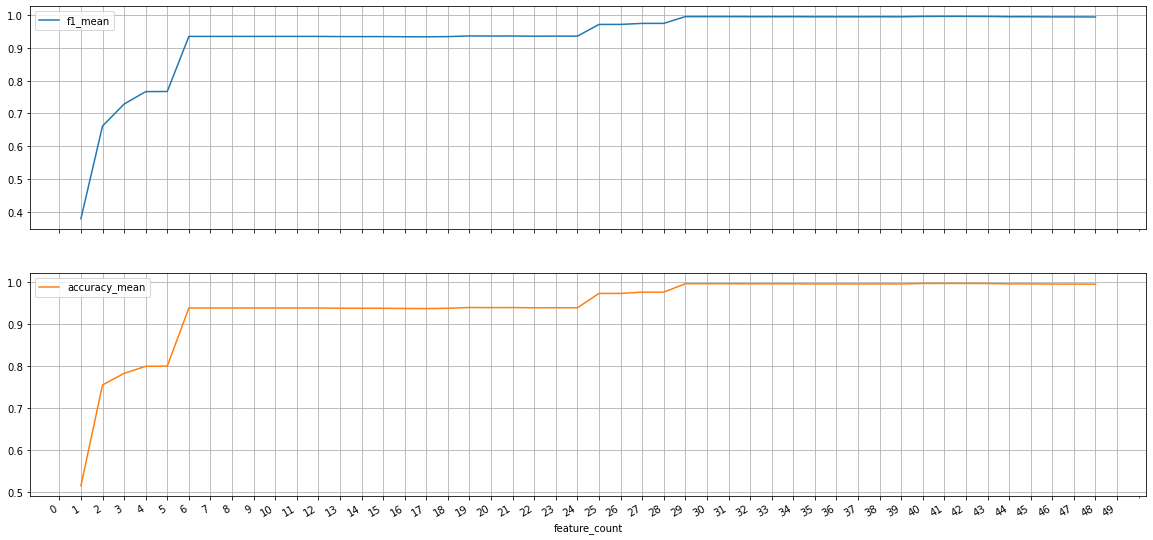

In [4]:
args = {'figsize': (20, 10), 
        'subplots': True, 
        'grid': True, 
        'xticks': range(0,50,1)}

results.plot.line(y=['f1_mean', 'accuracy_mean'], x='feature_count', **args);